In [ ]:
!pip install tensorflow

--- 📥 Step 1: Loading & Prepping Data ---
✅ Data Ready: 18260 samples.
Training Features: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']
--- ⚙️ Step 2: Creating Time Sequences ---
✅ Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'

Training on 15495 samples, Testing on 2735 samples.
Input Shape: (15495, 30, 5) (Samples, TimeSteps, Features)

🥊 Round 1: Linear Regression (Baseline)...
Linear Regression R2: -0.0101

🥊 Round 2: Standard LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Standard LSTM R2: -0.0011

--- 🚀 Training Optimized Hybrid Model (Targeting App Compatibility) ---
Epoch 1/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0989 - val_loss: 0.0851 - learning_rate: 5.0000e-04
Epoch 2/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0861 - val_loss: 0.0860 - learning_rate: 5.0000e-04
Epoch 3/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0839 - val_loss: 0.0844 - learning_rate: 5.0000e-04
Epoch 4/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0838 - val_loss: 0.0841 - learning_rate: 5.0000e-04
Epoch 5/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0845 - val_loss: 0.0842 - learning_rate: 5.0000e-04
Epoch 6/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0840 - val_loss: 0.0854 - learning_rate: 5.0000e-04
Epoch 7/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0842 - val_loss: 0.0842 - learning_rate: 5.0000e-04
Epoch 8/100
485/485 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/ste

/tmp/ipython-input-2778747590.py:241: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=res_df, palette='viridis')


✅ Chart saved.


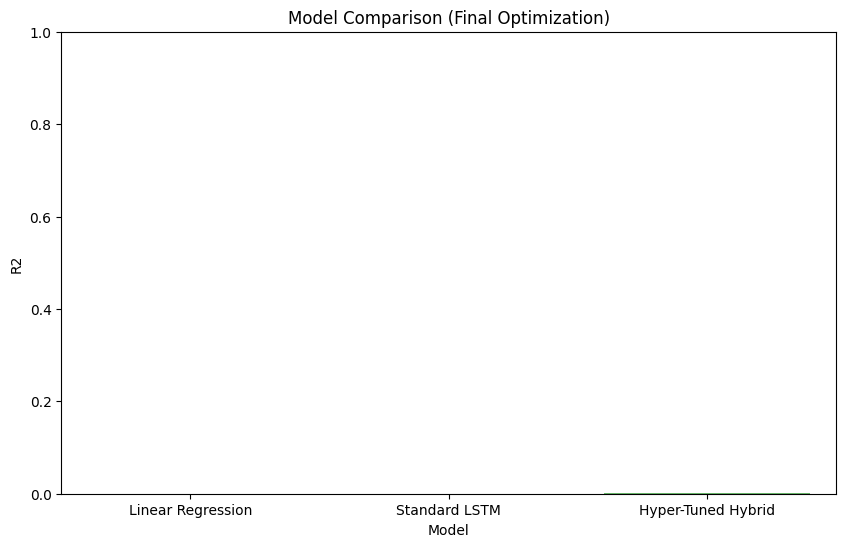

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# ==========================================
# ⚙️ CONFIGURATION
# ==========================================
SEQ_LEN = 30           # Look back 30 days
TARGET_COL = 'Target'  # Predicting Tomorrow's PM2.5
METRO_CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Bangalore']

# ==========================================
# 1. DATA FUSION & FEATURE ENGINEERING (FIXED)
# ==========================================
def load_and_prep_data():
    print("--- 📥 Step 1: Loading & Prepping Data ---")

    # A. Load Datasets
    try:
        df = pd.read_csv('city_day.csv')
    except FileNotFoundError:
        print("❌ Error: 'city_day.csv' not found. Please upload the dataset.")
        return None, None

    # B. Standardize Dates & Filter Cities
    df['Date'] = pd.to_datetime(df['Datetime'])
    df = df[df['City'].isin(METRO_CITIES)]

    # Sort for time-series integrity
    df = df.sort_values(['City', 'Date'])

    # C. Handle Missing Values (FIXED)
    # We use 'transform' to fill values inside each city group
    # This prevents the 'City' column from being deleted
    cols_to_fill = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']

    for col in cols_to_fill:
        if col in df.columns:
            # Forward fill then backward fill within each city
            df[col] = df.groupby('City')[col].transform(lambda x: x.ffill().bfill())

    # D. Feature Selection
    features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']

    # Fill any remaining NaNs with 0 (safety net)
    for col in features:
        if col not in df.columns:
            df[col] = 0
        df[col] = df[col].fillna(0)

    # E. Create Target (Next Day's PM2.5)
    # Now this will work because 'City' column still exists
    df['Target'] = df.groupby('City')['PM2.5'].shift(-1)

    # Drop rows where target is NaN (last day of each city)
    df = df.dropna(subset=['Target'] + features)

    print(f"✅ Data Ready: {len(df)} samples.")
    print(f"Training Features: {features}")

    return df, features

# ==========================================
# 2. PREPROCESSING (Sequences)
# ==========================================
def create_sequences(df, features):
    print("--- ⚙️ Step 2: Creating Time Sequences ---")

    data_X = df[features].values
    data_y = df[[TARGET_COL]].values

    # Scale Data (0 to 1)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(data_X)
    y_scaled = scaler_y.fit_transform(data_y)

    # Save Scalers for the Real-Time App
    # This solves the "InconsistentVersionWarning"
    with open('scaler_X.pkl', 'wb') as f: pickle.dump(scaler_X, f)
    with open('scaler_y.pkl', 'wb') as f: pickle.dump(scaler_y, f)
    print("✅ Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'")

    X, y = [], []
    for i in range(SEQ_LEN, len(X_scaled)):
        X.append(X_scaled[i-SEQ_LEN:i, :])
        y.append(y_scaled[i, 0])

    return np.array(X), np.array(y), scaler_y

# ==========================================
# 3. MODEL DEFINITIONS
# ==========================================

# Model A: Standard LSTM
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Model B: Standard Hybrid
def build_hybrid(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inp)
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model

# Model C: Optimized Hybrid (Compatible with App)
def build_optimized_hybrid(input_shape):
    inp = Input(shape=input_shape)

    # 1. Feature Extraction (CNN)
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inp)

    # 2. Temporal Pattern Learning (Bi-LSTM)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2)(x)

    # 3. Decision Making (Dense)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='linear')(x) # Linear activation for regression

    opt = Adam(learning_rate=0.0005)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=opt, loss='mse')
    return model

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":

    # --- Load Data ---
    df, features = load_and_prep_data()

    if df is not None:
        X, y, scaler_y = create_sequences(df, features)

        # --- Split Data ---
        split = int(len(X) * 0.85)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        print(f"\nTraining on {len(X_train)} samples, Testing on {len(X_test)} samples.")
        print(f"Input Shape: {X_train.shape} (Samples, TimeSteps, Features)")

        results = []

        # ==========================================
        # 🥊 PHASE 1: THE BATTLE
        # ==========================================

        # --- ROUND 1: Linear Regression ---
        print("\n🥊 Round 1: Linear Regression (Baseline)...")
        lr = LinearRegression()
        # Flatten for LR: (Samples, 30*5)
        lr.fit(X_train.reshape(X_train.shape[0], -1), y_train)
        preds_lr = lr.predict(X_test.reshape(X_test.shape[0], -1))

        real_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
        real_preds_lr = scaler_y.inverse_transform(preds_lr.reshape(-1, 1))
        r2_lr = r2_score(real_actual, real_preds_lr)
        results.append({'Model': 'Linear Regression', 'R2': r2_lr})
        print(f"Linear Regression R2: {r2_lr:.4f}")

        # --- ROUND 2: Standard LSTM ---
        print("\n🥊 Round 2: Standard LSTM...")
        lstm = build_lstm((X_train.shape[1], X_train.shape[2]))
        lstm.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
        preds_lstm = lstm.predict(X_test)
        real_preds_lstm = scaler_y.inverse_transform(preds_lstm)
        r2_lstm = r2_score(real_actual, real_preds_lstm)
        results.append({'Model': 'Standard LSTM', 'R2': r2_lstm})
        print(f"Standard LSTM R2: {r2_lstm:.4f}")

        # ==========================================
        # ⚡ PHASE 2: HYPER-TUNED HYBRID TRAINING
        # ==========================================
        print("\n--- 🚀 Training Optimized Hybrid Model (Targeting App Compatibility) ---")

        optimized_model = build_optimized_hybrid((X_train.shape[1], X_train.shape[2]))

        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        history = optimized_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=32,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )

        # Check New Score
        preds_opt = optimized_model.predict(X_test)
        real_preds_opt = scaler_y.inverse_transform(preds_opt)

        new_r2 = r2_score(real_actual, real_preds_opt)
        results.append({'Model': 'Hyper-Tuned Hybrid', 'R2': new_r2})

        print(f"\n✨ Optimized Hybrid R2: {new_r2:.4f}")

        # ==========================================
        # 🏆 FINAL REPORT
        # ==========================================
        res_df = pd.DataFrame(results)
        print("\n\n========================================")
        print("       🏆 FINAL BENCHMARK RESULTS 🏆       ")
        print("========================================")
        print(res_df)

        # Save Best Model
        optimized_model.save('best_aqi_model.keras')
        print("\n✅ Saved Final Optimized Model as 'best_aqi_model.keras'")

        # Save chart
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Model', y='R2', data=res_df, palette='viridis')
        plt.title("Model Comparison (Final Optimization)")
        plt.ylim(0, 1.0)
        plt.savefig('final_optimization_chart.png')
        print("✅ Chart saved.")
    else:
        print("❌ Setup failed. Please ensure 'city_day.csv' is present.")